# Face pos Estimation using dlib

## collect data

In [1]:
import scipy.io as sio
import os 
import glob
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor 


from joblib import dump, load

from imutils import face_utils

import dlib
import cv2

In [2]:
f_path =  os.getcwd()
path =r'c:\\Users\\ahmed\\Downloads\\AFLW2000\\data'
os.chdir(path)
matfiles= [file for file in glob.glob("*.mat")]

listof_points=[]
listof_pos=[]
imagename=[]

for i in range(0,len(matfiles)):
    mm = sio.loadmat(matfiles[i])
    pos = mm['Pose_Para'][0][:3]#*180/np.pi #Yaw pitch roll
    points = mm['pt3d_68']
    listof_points.append(np.concatenate((points[0],points[1])).astype(np.int32))
    listof_pos.append(pos)
    imagename.append(matfiles[i][:-4])
os.chdir(f_path)

In [3]:
#naming columns 
cols = {}
for i in range(68):
    # if i%2==0:
    cols.update({i:"x"+str(i)})
    # else:
    cols.update({i+68:"y"+str(i)})
#repose columns to be x,y
repos_col = []
for i in range(68):
    repos_col.append(i)
    repos_col.append(i+68)

In [4]:
df1 =pd.DataFrame(listof_points,)
df2 = pd.DataFrame(listof_pos,columns=["pitch","yaw","roll"])
df3 = pd.DataFrame(imagename,columns=["image"])

In [5]:
df1= df1[repos_col]
df1.rename(columns=cols, inplace=True)
df = pd.concat([df1,df2,df3],axis=1)
df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x65,y65,x66,y66,x67,y67,pitch,yaw,roll,image
0,121,167,122,197,126,225,130,250,137,280,...,227,330,213,330,201,324,-0.399231,0.018227,0.085676,image00002
1,281,265,277,287,274,307,269,324,257,340,...,203,299,199,300,197,302,0.470065,1.189533,0.300959,image00004
2,236,239,239,259,242,277,243,294,242,314,...,226,303,219,304,215,304,-0.184650,0.881137,-0.236852,image00006
3,168,256,177,277,190,295,201,311,211,329,...,247,315,239,319,232,320,-0.175379,0.299208,-0.373374,image00008
4,280,236,287,259,293,279,297,297,295,315,...,211,311,208,312,209,312,-0.882169,1.198004,-1.033374,image00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,112,195,113,226,119,254,125,278,133,303,...,229,324,219,324,209,322,-0.197102,-0.070430,0.105118,image04358
1996,111,243,113,268,115,291,120,312,134,335,...,242,316,243,317,241,318,-0.232617,-1.418751,0.175960,image04363
1997,308,235,309,260,311,283,310,304,303,326,...,210,314,209,315,211,313,-1.447955,1.431267,-1.509418,image04364
1998,106,208,106,237,107,264,109,287,116,314,...,242,313,241,313,235,312,-0.420465,-1.191176,0.451515,image04365


In [6]:
df.to_csv("imagesPointData__raduis.csv",index=False)

## data analysis

In [7]:
df = pd.read_csv('imagesPointData__raduis.csv',)

In [8]:
df[['pitch','yaw','roll']].describe()

,pitch,yaw,roll
count,2000.000000,2000.000000,2000.000000
mean,-0.107145,0.014077,-0.034479
std,0.628119,0.654185,0.716014
min,-12.457202,-6.130066,-16.969362
25%,-0.258503,-0.294246,-0.174806
50%,-0.122268,0.019702,-0.018098
75%,0.040192,0.334715,0.134378
max,15.598820,3.277500,5.829394


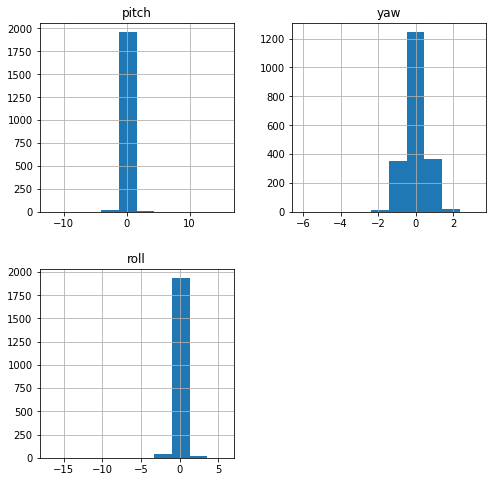

In [9]:

df[['pitch','yaw','roll']].hist(figsize=(8,8))

fig = go.Figure()
fig.add_trace(go.Box(y= df['pitch'],name="pitch"),)
fig.add_trace(go.Box(y=df['yaw'],name= "yaw"))
fig.add_trace(go.Box(y=df['roll'],name = "roll"))

fig.show()

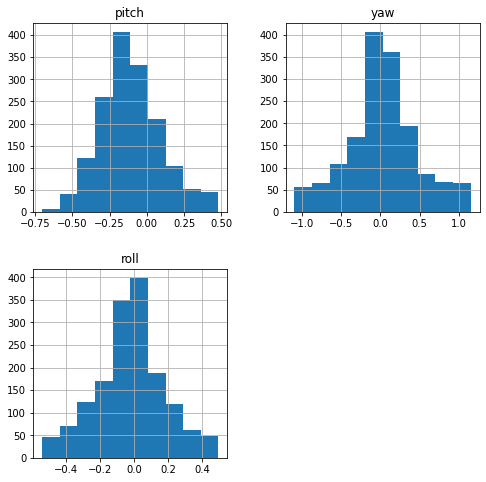

In [10]:
#delete outliers in pitch and yaw
for col in ['pitch','yaw','roll']:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    max = df[col].quantile(0.75) +1.5*IQR
    min = df[col].quantile(0.25) -1.5*IQR 
    outlierdf = df[(df[col] > max) | (df[col] < min)]
    df.drop(df[(df[col] > max) | (df[col] < min)].index, inplace=True)


df[['pitch','yaw','roll']].hist(figsize=(8,8))

fig = go.Figure()
fig.add_trace(go.Box(y= df['pitch'],name="pitch"),)
fig.add_trace(go.Box(y=df['yaw'],name= "yaw"))
fig.add_trace(go.Box(y=df['roll'],name = "roll"))

fig.show()

In [11]:
outlierdf.to_csv("outlierdf.csv",index=False)
outlierdf

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x65,y65,x66,y66,x67,y67,pitch,yaw,roll,image
15,124,169,117,193,114,215,112,237,112,264,...,223,311,217,309,210,307,-0.451313,-0.492805,0.505595,image00035
71,144,146,129,177,117,207,109,233,104,262,...,205,326,195,321,185,314,-0.167281,0.011618,0.585010,image00102
87,155,162,145,188,139,212,134,235,131,263,...,214,322,202,317,190,309,-0.156937,0.017260,0.512046,image00135
100,124,292,141,313,161,332,178,346,197,360,...,257,294,248,301,241,307,-0.048813,0.065417,-0.583348,image00159
125,107,363,137,372,165,377,192,381,223,383,...,291,281,286,295,280,307,0.018328,-0.332684,-1.188444,image00204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,130,170,121,194,115,216,110,238,110,264,...,224,308,217,306,209,302,-0.332272,-0.408635,0.533506,image04018
1866,181,128,160,145,143,162,129,180,119,203,...,187,313,180,305,174,293,-0.379047,-0.301894,1.106254,image04024
1891,245,198,231,222,220,245,208,265,195,287,...,200,308,193,302,188,296,0.185887,0.601698,0.673786,image04120
1907,128,186,122,207,117,226,115,245,119,269,...,226,312,222,309,217,304,-0.272341,-0.907773,0.649467,image04172


In [12]:
# investigat outlier images
outlierdf[outlierdf['pitch'] == outlierdf['pitch'].max()]

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x65,y65,x66,y66,x67,y67,pitch,yaw,roll,image
466,97,277,107,299,118,318,130,334,151,348,...,261,293,258,294,252,295,0.477994,-0.914508,-0.577919,image00781


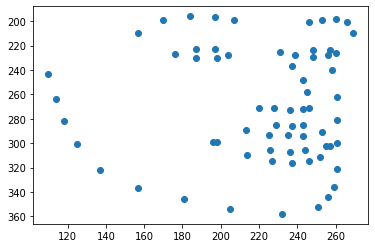

In [13]:
#display points for one row before normalization
row =200
plt.scatter(x=df.iloc[row,:-4:2],y=df.iloc[row,1:-4:2])
plt.gca().invert_yaxis()


In [14]:
######################################normalize and resenter points
df.iloc[:,:-4:2]= (df.iloc[:,:-4:2].values /df['x30'].values.reshape(-1,1)) -1
df.iloc[:,1:-4:2] = (df.iloc[:,1:-4:2].values /  df['y30'].values.reshape(-1,1))-1 

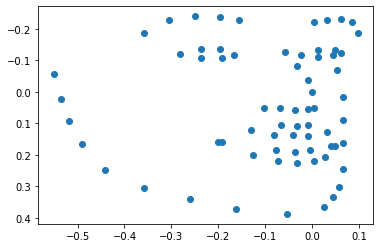

In [15]:
#display points for same row after normalization
row =200
plt.scatter(x=df.iloc[row,:-4:2],y=df.iloc[row,1:-4:2])
plt.gca().invert_yaxis()


## select features and split data

In [16]:
#reduse features choose specific features
lpoints = [2,3,4,8,9,10,12,13,14,18,20,23,27,30,34,37,40,43,46,52,58]
extract = []
for p in lpoints :
    extract.append("x"+str(p))
    extract.append("y"+str(p))
# extract.extend(['pitch',	'yaw'	,'roll'])
df= pd.concat([df[extract] ,df.iloc[:,-4:]],axis=1)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,0:-4],
df.iloc[:,-4:-1],test_size=0.2)
print(X_train.shape)
print(X_test.shape)
X_train

(1264, 42)
(316, 42)


,x2,y2,x3,y3,x4,y4,x8,y8,x9,y9,...,x40,y40,x43,y43,x46,y46,x52,y52,x58,y58
658,-0.500000,-0.078571,-0.478632,0.010714,-0.444444,0.107143,-0.047009,0.350000,0.094017,0.325000,...,-0.188034,-0.225000,0.166667,-0.257143,0.222222,-0.217857,0.029915,0.092857,-0.081197,0.189286
780,-0.427948,0.076923,-0.384279,0.153846,-0.331878,0.234432,0.043668,0.377289,0.157205,0.336996,...,-0.200873,-0.139194,0.091703,-0.230769,0.152838,-0.197802,0.043668,0.117216,-0.017467,0.216117
1937,-0.556452,0.045113,-0.524194,0.120301,-0.467742,0.203008,-0.072581,0.360902,-0.004032,0.330827,...,-0.213710,-0.139098,0.024194,-0.187970,0.052419,-0.154135,-0.020161,0.082707,-0.092742,0.203008
650,-0.043478,0.052239,-0.019324,0.123134,0.004831,0.190299,0.135266,0.313433,0.256039,0.291045,...,-0.057971,-0.134328,0.217391,-0.190299,0.275362,-0.152985,0.086957,0.104478,0.019324,0.160448
668,-0.580087,-0.100000,-0.549784,0.000000,-0.493506,0.110714,0.000000,0.339286,0.138528,0.296429,...,-0.225108,-0.200000,0.142857,-0.271429,0.207792,-0.232143,0.038961,0.092857,-0.060606,0.178571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,-0.214634,0.217742,-0.204878,0.294355,-0.195122,0.370968,0.024390,0.475806,0.175610,0.467742,...,-0.078049,-0.108871,0.268293,-0.145161,0.326829,-0.100806,0.048780,0.133065,-0.053659,0.258065
725,-0.274419,0.189723,-0.255814,0.268775,-0.227907,0.343874,0.037209,0.470356,0.172093,0.450593,...,-0.130233,-0.106719,0.204651,-0.154150,0.251163,-0.114625,0.041860,0.150198,-0.018605,0.249012
176,-0.557018,0.500000,-0.504386,0.600000,-0.434211,0.686957,0.078947,0.626087,0.236842,0.613043,...,-0.258772,-0.043478,0.153509,-0.126087,0.228070,-0.095652,0.092105,0.217391,0.008772,0.347826
1462,-0.412017,0.110266,-0.377682,0.182510,-0.339056,0.258555,-0.038627,0.433460,0.068670,0.410646,...,-0.180258,-0.159696,0.128755,-0.193916,0.175966,-0.152091,0.017167,0.136882,-0.068670,0.239544


In [18]:
Y_train

,pitch,yaw,roll
658,-0.236469,-0.087331,0.043374
780,-0.071779,-0.089700,-0.165574
1937,-0.004513,-0.561145,-0.070741
650,-0.052379,0.456169,-0.082544
668,-0.330235,-0.137703,-0.039391
...,...,...,...
405,0.280331,0.292501,0.120772
725,0.209882,0.199380,-0.001838
176,0.418088,-0.059293,-0.149454
1462,0.059729,-0.107011,-0.004487


### gradientbosst model

In [19]:
clf = make_pipeline(#MinMaxScaler(),
                     #PCA(n_components=7),
                    MultiOutputRegressor(GradientBoostingRegressor(random_state=0,n_estimators=200,learning_rate=0.4,max_depth=5),n_jobs=-1)
                    )

clf.fit(X_train, Y_train)
predictions =  clf.predict(X_train.values)
print(mean_squared_error(Y_train, predictions))
print(r2_score(Y_train, predictions))
print("#######################################")
test_predictions =  clf.predict(X_test.values)
print(mean_squared_error(Y_test, test_predictions))
print(r2_score(Y_test, test_predictions))
print("#######################################")
# test_predictions =  clf.predict(X_test.values)
print(r2_score(Y_test['pitch'], test_predictions[:,0]))
print(r2_score(Y_test['yaw'], test_predictions[:,1]))
print(r2_score(Y_test['roll'], test_predictions[:,2]))

4.661594998432289e-09
0.9999998983036748
#######################################
0.0011055716651788337
0.976353177216177
#######################################
0.9563204005695591
0.9973724455172085
0.9753666855617633


In [20]:
dump(clf, '../models/GradientBoostingRegressor.joblib')

['../models/GradientBoostingRegressor.joblib']

### RandomForestRegressor model

In [21]:
random_clf = make_pipeline(#StandardScaler(),
                    #  PCA(n_components=7),
                    MultiOutputRegressor(RandomForestRegressor(random_state=0,n_estimators=1000,max_depth=6,n_jobs=-1),n_jobs=-1) #best time to score when 6000 6
                    )

random_clf.fit(X_train.values, Y_train.values)
predictions =  random_clf.predict(X_train.values)
print(mean_squared_error(Y_train.values, predictions))
print(r2_score(Y_train.values, predictions))
print("#######################################")
test_predictions =  random_clf.predict(X_test.values)
print(mean_squared_error(Y_test, test_predictions))
print(r2_score(Y_test, test_predictions))
print("#######################################")
# test_predictions =  random_clf.predict(X_test.values)
print(r2_score(Y_test['pitch'], test_predictions[:,0]))
print(r2_score(Y_test['yaw'], test_predictions[:,1]))
print(r2_score(Y_test['roll'], test_predictions[:,2]))

0.0006873983682635056
0.985944387274973
#######################################
0.0013373740760154243
0.9723649577132091
#######################################
0.9533434846827282
0.995892528649121
0.967858859807778


In [22]:
dump(random_clf, '../models/RandomForestRegressor.joblib')

['../models/RandomForestRegressor.joblib']

### XGBRegressor

In [23]:
xg_clf = make_pipeline(StandardScaler(),
                    #PCA(n_components=7),
                    MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, nthread=-1,seed=0),n_jobs=-1)
                    )

xg_clf.fit(X_train.values, Y_train.values)

predictions =  xg_clf.predict(X_train.values)
print(mean_squared_error(Y_train.values, predictions))
print(r2_score(Y_train.values, predictions))
print("#######################################")
test_predictions =  xg_clf.predict(X_test.values)
print(mean_squared_error(Y_test, test_predictions))
print(r2_score(Y_test, test_predictions))
print("#######################################")
# test_predictions =  xg_clf.predict(X_test.values)
print(r2_score(Y_test['pitch'], test_predictions[:,0]))
print(r2_score(Y_test['yaw'], test_predictions[:,1]))
print(r2_score(Y_test['roll'], test_predictions[:,2]))

0.00021801753847491725
0.9953693018368718
#######################################
0.0009462867798579665
0.9795848337772829
#######################################
0.9650152312599907
0.9978781366854332
0.975861133386425


In [24]:
dump(xg_clf, '../models/XGBRegressor.joblib')

['../models/XGBRegressor.joblib']

### VotingRegressor 

In [25]:
voting_clf = make_pipeline(StandardScaler(),
        #PCA(n_components=10),
        MultiOutputRegressor(VotingRegressor(
            estimators=[
            ('rf', RandomForestRegressor(random_state=0,n_estimators=1000,max_depth=6,n_jobs=-1)),('xgb',XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, nthread=-1,seed=0))
             ]),n_jobs=-1)
)
voting_clf.fit(X_train.values, Y_train.values)
predictions =  voting_clf.predict(X_train.values)
print(mean_squared_error(Y_train.values, predictions))
print(r2_score(Y_train.values, predictions))
test_predictions =  voting_clf.predict(X_test.values)
print("#######################################")
print(mean_squared_error(Y_test, test_predictions))
print(r2_score(Y_test, test_predictions))
# test_predictions =  voting_clf.predict(X_test.values)
print("#######################################")
print(r2_score(Y_test['pitch'], test_predictions[:,0]))
print(r2_score(Y_test['yaw'], test_predictions[:,1]))
print(r2_score(Y_test['roll'], test_predictions[:,2]))

0.00035586604775788357
0.9925591471651177
#######################################
0.0010339617968780227
0.9780454819354355
#######################################
0.9619471721794041
0.9973681855130921
0.9748210881138105


In [26]:
dump(voting_clf, '../models/VotingRegressor.joblib')

['../models/VotingRegressor.joblib']

# predict

In [27]:
model = load('../models/XGBRegressor.joblib')

In [28]:
def draw_axis(img,pitch, yaw,  roll, tdx=None, tdy=None, size = 100):
    
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [29]:
predictor=dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()

## predict video

In [30]:
import cv2 as cv
cap = cv2.VideoCapture(0)
# frame = cv2.imread("../test/2177168298_1.jpg")
pit = yaw =rol = tdx = tdy =0
while(cap.isOpened()):
    # load the input image and convert it to grayscale
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    dets = cnn_face_detector(gray, 1)
    # print(dets)
    for (idx, det) in enumerate(dets):
                
        shape = predictor(gray, det)
        shape = face_utils.shape_to_np(shape)
        sss = shape.reshape(1,-1)
        sss=sss[ :,[  4,   5,   6,   7,   8,   9,  16,  17,  18,  19,  20,  21,  24,
        25,  26,  27,  28,  29,  36,  37,  40,  41,  46,  47,  54,  55,
        60,  61,  68,  69,  74,  75,  80,  81,  86,  87,  92,  93, 104,
       105, 116, 117]]
        fff = sss.flatten().astype(float)

        fff[::2] = (fff[::2] /fff[26]) - 1 #60
        fff[1::2] = (fff[1::2] /fff[27]) -1 #61
        fff =fff.reshape(1,-1)
        predict = model.predict(fff)
        cv2.putText(frame,'yaw : '+str(predict[0,0]), (0, 20), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'pitch : ' + str(predict[0,1]), (0, 50), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'roll : '+ str(predict[0,2]), (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (246,255,12),2)

        pit=predict[0,0]
        yaw=-predict[0,1]
        rol=predict[0,2]
        yawlook = ""
        pitlook = ""
        rolllook = ""
        if np.tan(yaw)>0.17632698070846498 and np.tan(yaw)<0.9999999999999999:
            yawlook ="look right"
        elif np.tan(yaw)<-0.17632698070846498 and np.tan(yaw)>-0.9999999999999999:
            yawlook =  "look left"

        #pitch look up and down
        if np.tan(pit)>0.17632698070846498 and np.tan(pit)<0.9999999999999999:
           pitlook = "look up"
        elif np.tan(pit)<-0.17632698070846498 and np.tan(pit)>-0.9999999999999999:
           pitlook = "look down"
        #roll shake left and right
        if np.tan(rol)>0.17632698070846498 and np.tan(rol)<0.9999999999999999:
            rolllook = "shake right"
        elif np.tan(rol)<-0.17632698070846498 and np.tan(rol)>-0.9999999999999999:
            rolllook = "shake left"
        jj=0
        for (x, y) in shape:
            
            cv2.putText(frame,str(jj), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (246,255,12), 3)
            jj +=1

        cv2.putText(frame,'yaw : '+yawlook, (0, 220), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'pitch : ' + pitlook, (0, 250), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'roll : '+ rolllook, (0, 280), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (246,255,12),2)
        tdx,tdy=shape[30,0], shape[30,1]
        # bbox_height, bbox_width = frame.shape[:2]
                
    cv2.imshow("Output",draw_axis(frame,pit,yaw,rol,tdx,tdy))

    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
                
cv2.destroyAllWindows()

## predict folder of images

In [31]:
pit = yaw =rol = tdx = tdy =0
for img in os.listdir("../test") :
    frame = cv2.imread(os.path.join("../test",img))
    cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

    dets = cnn_face_detector(cv2_frame, 1)
    # print(dets)
    for (idx, det) in enumerate(dets):
                
        shape = predictor(cv2_frame, det)
        shape = face_utils.shape_to_np(shape)
        sss = shape.reshape(1,-1)
        sss=sss[ :,[  4,   5,   6,   7,   8,   9,  16,  17,  18,  19,  20,  21,  24,
        25,  26,  27,  28,  29,  36,  37,  40,  41,  46,  47,  54,  55,
        60,  61,  68,  69,  74,  75,  80,  81,  86,  87,  92,  93, 104,
       105, 116, 117]]
        fff = sss.flatten().astype(float)

        fff[::2] = (fff[::2] /fff[26]) - 1 #60
        fff[1::2] = (fff[1::2] /fff[27]) -1 #61
        fff =fff.reshape(1,-1)
        predict = model.predict(fff)

        cv2.putText(frame,'yaw : '+str(predict[0,0]), (0, 20), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'pitch : ' + str(predict[0,1]), (0, 50), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'roll : '+ str(predict[0,2]), (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (246,255,12),2)

        
        pit=predict[0,0]
        yaw=-predict[0,1]
        rol=predict[0,2]
        #yaw look left and right
        yawlook = ""
        pitlook = ""
        rolllook = ""
        if np.tan(yaw)>0.17632698070846498 and np.tan(yaw)<0.9999999999999999:
            yawlook = "look left"
        elif np.tan(yaw)<-0.17632698070846498 and np.tan(yaw)>-0.9999999999999999:
            yawlook = "look right"

        #pitch look up and down
        if np.tan(pit)>0.17632698070846498 and np.tan(pit)<0.9999999999999999:
            pitlook = "look up"
        elif np.tan(pit)<-0.17632698070846498 and np.tan(pit)>-0.9999999999999999:
            pitlook = "look down"
    #roll shake left and right
        if np.tan(rol)>0.17632698070846498 and np.tan(rol)<0.9999999999999999:
            rolllook = "shake left"
        elif np.tan(rol)<-0.17632698070846498 and np.tan(rol)>-0.9999999999999999:
            rolllook = "shake right"
        jj=0
        for (x, y) in shape:
            
            cv2.putText(frame,str(jj), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (246,255,12), 3)
            jj +=1

        cv2.putText(frame,'yaw : '+yawlook, (0, 220), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'pitch : ' + pitlook, (0, 250), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
        cv2.putText(frame,'roll : '+ rolllook, (0, 280), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (246,255,12),2)
        tdx,tdy=shape[30,0], shape[30,1]
        # bbox_height, bbox_width = frame.shape[:2]
                
        cv2.imwrite(os.path.join("../result",img),draw_axis(frame,pit,yaw,rol,tdx,tdy))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    